# Machine Learning with scikit-learn

Sometimes the features you have available in your initial data have little predictive strength when used in the most straightforward way.  This might be true almost regardless of choice of model class and hyperparameters.  And yet it might also be true that there are synthetic features latent in the data that are highly predictive, but that have to be *engineered* (mechanically, rather than sample-wise modification) to produce powerful features.

At the same time, a highly dimension model—whether of high dimension because of the initial data collection or because of creation of extra synthetic features—may lend itself less well to modeling techniques.  In these cases, it can be more computationally tractable, as well as more predictive, to work with a subset of all available features.

This is the second part of what can be thought of broadly as "Feature Engineering." This part focuses on selecting the features of most relevance. 

In [1]:
# Some libraries tend to be in flux for their dependency versions
import warnings
warnings.simplefilter("ignore")

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

%matplotlib inline


## Feature Selection

One way to reduce features in a dataset is to throw some of them away.  In principle, features thrown away can be engineered features such as those resulting from decompositions or those discussed below that are combined or synthesized from raw features.  Scikit-learn gives you several ways to choose features to discard; or euqivalently, features to keep.

There are several univariate feature selectors in scikit-learn.  `SelectKBest` is essentially the same as `SelectPercentile`, merely different in whether you indicate a number of percentage of features to keep.  Obviously, it is easy to derive one from the other based on number of features in the raw data. Just slightly different are false positive rate (`SelectFpr`), false discovery rate (`SelectFdr`), or family wise error (`SelectFwe`).  

All of these let you specify a scoring function the judges the quality of the estimate using just one feature.  For regression, there are `f_regression`, `mutual_info_regression`; for classification: `chi2`, `f_classif`, `mutual_info_classif`.  You can also, in principle, use a custom function to evaluate strength of a single feature for prediction.

In [2]:
cancer = load_breast_cancer()

### Univariate

Let us look at the Wisconsin cancer dataset from perspective of simply identifying the most important features (in the raw dataset).  Notice that we use the entire dataset for this purpose, not only a training portion of it.

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=5)
X_new = selector.fit_transform(cancer.data, cancer.target)
cancer.data.shape, X_new.shape

((569, 30), (569, 5))

In [4]:
kbest = pd.Series(selector.scores_, index=cancer.feature_names).sort_values(ascending=False)
kbest.head(10)

worst area         112598.431564
mean area           53991.655924
area error           8758.504705
worst perimeter      3665.035416
mean perimeter       2011.102864
worst radius          491.689157
mean radius           266.104917
perimeter error       250.571896
worst texture         174.449400
mean texture           93.897508
dtype: float64

Let us take a look at how models work with all 30 features versus with just the top 5 in a univariate filter.  In this example, we do not get better with this step alone (but KNN doesn't get much worse), but in some cases the score will actually improve without surplus dimensions.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
lr, knn = LinearRegression(), KNeighborsClassifier()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=1)
print("Fit raw features:")
print(" LR:", lr.fit(X_train, y_train).score(X_test, y_test))
print("KNN:", knn.fit(X_train, y_train).score(X_test, y_test))

Fit raw features:
 LR: 0.722268601197212
KNN: 0.9370629370629371


We do *worse* with only five of the thirty features, but for KNN, not very much worse!

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, cancer.target, random_state=1)
print("Fit selected features:")
print(" LR:", lr.fit(X_train, y_train).score(X_test, y_test))
print("KNN:", knn.fit(X_train, y_train).score(X_test, y_test))

Fit selected features:
 LR: 0.5857835011372031
KNN: 0.9230769230769231


### Model-based Feature Selection

A number of selectors are based on the chosen underlying model itself rather on univariate strengths of features.  This only works with models than expose a `.coef_` or `.feature_importances_` attribute on a trained model.  Not all algorithms allow the determination of those values.

We look here at recursive feature elimination which is based on a model, and arrives at the most important features by eliminating the least important, then refitting based on those that remain, and doing so repeatedly until only the number of features requested remain.  The selector `SelectFromModel` works in a similar way, but recursive selection will generally be better quality (albeit **much** slower since it involves repeated refitting).

In [8]:
# Recursive feature elimination
from sklearn.feature_selection import RFE

lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=5, step=1) 
rfe.fit(cancer.data, cancer.target)

pd.Series(rfe.ranking_, index=cancer.feature_names).sort_values(ascending=False).head(10)

mean area            26
worst area           25
mean texture         24
area error           23
worst perimeter      22
texture error        21
worst texture        20
worst compactness    19
mean perimeter       18
mean radius          17
dtype: int32

The relative importance of features is similar, but somewhat different under recursive feature elimination than under K-best selection.  Given the nature of linear models, we mostly expect univariate elimination to behave similarly to recursive elimination based on linear regression.  Something like a decision tree (which provides `.feature_importances_`) might have a more different ranking of selected features.

We can go farther here and use `RFECV` to recursive eliminate features, cross-validate the model at each stage, and keep a record of the relationship between model score and number of features.

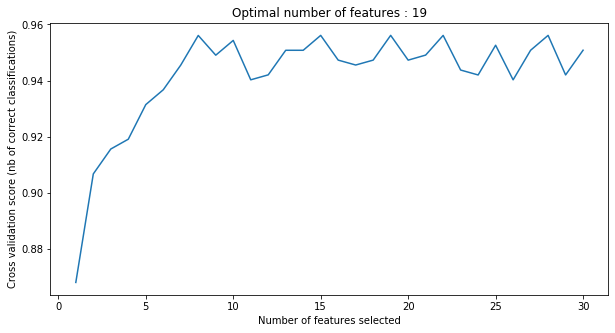

In [9]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

rf = RandomForestClassifier(max_depth=7, random_state=1)
rfecv = RFECV(estimator=rf)
rfecv.fit(cancer.data, cancer.target)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.show()